In [95]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import cv2
import numpy as np
import PIL
import PIL.Image
import json

In [2]:
def centroid_histogram(clt):
	# grab the number of different clusters and create a histogram
	# based on the number of pixels assigned to each cluster
	numLabels = np.arange(0, len(np.unique(clt.labels_)) + 1)
	(hist, _) = np.histogram(clt.labels_, bins = numLabels)
	# normalize the histogram, such that it sums to one
	hist = hist.astype("float")
	hist /= hist.sum()
	# return the histogram
	return hist

In [3]:
def plot_colors(hist, centroids):
	# initialize the bar chart representing the relative frequency
	# of each of the colors
	bar = np.zeros((50, 300, 3), dtype = "uint8")
	startX = 0
	# loop over the percentage of each cluster and the color of
	# each cluster
	for (percent, color) in zip(hist, centroids):
		# plot the relative percentage of each cluster
		endX = startX + (percent * 300)
		cv2.rectangle(bar, (int(startX), 0), (int(endX), 50),
			color.astype("uint8").tolist(), -1)
		startX = endX
		print(color)
	# return the bar chart
	return bar

In [98]:
def find_color_locaiton(image,color_mask) : 
    _, component, cstats, ccenter = cv2.connectedComponentsWithStats(
    (color_mask==1).astype(np.uint8), connectivity=4)
    csize = [ci[-1] for ci in cstats[1:]]
    target_cid = csize.index(max(csize))+1
    center = ccenter[target_cid][::-1]
    coord = np.stack(np.where(component == target_cid)).T
    dist = np.linalg.norm(coord-center, axis=1)
    target_coord_id = np.argmin(dist)
    coord_h, coord_w = coord[target_coord_id]
    rgb=image[coord_h][coord_w]
    print(coord_w, coord_h, rgb)
    return coord_w, coord_h, rgb

In [ ]:
file_direct = "data/single_strokes/single_strokes_495/sunflowers_rendered_single_stroke_"
stroke_cluster = []
for stroke_num in range(1, 496) :
    data = []
    stroke_name = ""
    num = str(stroke_num)
    num_of_zeros = 4 - len(num)
    for i in range(num_of_zeros) :
        stroke_name += '0'
    stroke_name += num
    filname = file_direct +  stroke_name + ".png"
    image = np.array(PIL.Image.open(filname))
    tmp_image = image

    if image.shape[2] == 4:
        print("Input image includes alpha channel, simply dropout alpha channel.")
        image = image[:, :, :3]
    tmp_image = cv2.resize(image, ( int(image.shape[0]/2), int(image.shape[1]/2) ))
    zero_mask = (tmp_image == [255, 255, 255]).all(axis=2)
    tmp_image = tmp_image[zero_mask==0]
    # print(tmp_image.shape)

    clt = KMeans(n_clusters = 2)
    clt.fit(tmp_image)
    # silhouette_avg = []
    # best_silhouette = -1.0
    # best_cluster = 1
    # for i in range(2,4):
    #     clt = KMeans(n_clusters = i)
    #     clt.fit(tmp_image)
    #     silhouette = silhouette_score(tmp_image, clt.labels_)
    #     silhouette_avg.append(silhouette)
    #     if silhouette > best_silhouette :
    #         best_cluster = i
    #         best_silhouette = silhouette
    # plt.plot(range(2,4), silhouette_avg)
    # print(best_cluster)
    # clt = KMeans(n_clusters = best_cluster)
    # clt.fit(tmp_image)
    
    centers = clt.cluster_centers_.astype(int)
    color_list = []
    for center in centers:
    # 將中心點位置轉換為原始圖片大小
        center = center * 2
        # 找到最接近的像素位置
        r = int(round(center[0] / 2))
        g = int(round(center[1] / 2))
        b = int(round(center[2] / 2))
        color_list.append((r,g,b))
    # print(color_list)

    for color in color_list :

        color_mask =  np.zeros((image.shape[0], image.shape[1]))
        r = color[0]
        g = color[1]
        b = color[2]

        for w in range(image.shape[0]):
            for h in range(image.shape[1]):
                if r-10 <= image[w][h][0]  <= r+10 :
                    if g-10 <= image[w][h][1]  <= g+10 :
                        if b-10 <= image[w][h][2]  <= b+10 :
                            color_mask[w][h] = 1
        #print(len(color_mask[color_mask==1]))
        if len(color_mask[color_mask==1]) > 0 :
            coord_w, coord_h, rgb = find_color_locaiton(image,color_mask)
            # print(type(coord_w))
            data.append({'coord': [coord_w.tolist(), coord_h.tolist()] ,'color_rgb': rgb.tolist()})      
    stroke_cluster.append(data)
with open('pixels.json', 'w') as f:
    json.dump(stroke_cluster, f,indent=4)

[242.28888889 239.6         52.44444444]
[249.125  248.1875 173.875 ]


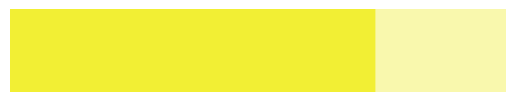

In [164]:
# build a histogram of clusters and then create a figure
# representing the number of pixels labeled to each color
hist = centroid_histogram(clt)
bar = plot_colors(hist, clt.cluster_centers_)
# show our color bart
plt.figure()
plt.axis("off")
plt.imshow(bar)
plt.show()

In [165]:
centers = clt.cluster_centers_.astype(int)
locations = []
for center in centers:
    # 將中心點位置轉換為原始圖片大小
    center = center * 2
    # 找到最接近的像素位置
    r = int(round(center[0] / 2))
    g = int(round(center[1] / 2))
    b = int(round(center[2] / 2))
    locations.append((r,g,b))

# 輸出每個中心點在圖片中的位置
print(locations)

[(242, 239, 52), (249, 248, 173)]


In [ ]:
rgb=[249, 248, 173]
image = np.array(PIL.Image.open(filname))
image = image[:,:,:3]
matches = []
m =  np.zeros((image.shape[0], image.shape[1]))
r = rgb[0]
g = rgb[1]
b = rgb[2]
for i in range(image.shape[0]):
    for j in range(image.shape[1]):
        print(image[i][j])
        if r-5 <= image[i][j][0]  <= r+5 :
            if g-5 <= image[i][j][1]  <= g+5 :
                if b-5 <= image[i][j][2]  <= b+5 :
                    m[i][j] = 1
        # if np.all(image[i][j] == rgb):
        #      matches.append((i, j))
print(len(m[m==1]))

#m = (image == rgb).all(axis=2)

In [ ]:
fig, ax = plt.subplots()
ax.imshow(image, cmap='gray')
for i in range(1, _):
    # 获取当前连通组件的外接矩形框信息
    x, y, w, h, area = cstats[i]
    print(area)
    rect = plt.Rectangle((x, y), w, h, linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

plt.show()

In [67]:
image = np.array(PIL.Image.open(filname))
img = image[:,:,:3]

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)

# 計算梯度幅值和方向
grad_dir = cv2.phase(sobelx, sobely, angleInDegrees=True)
quantized_dir = np.zeros_like(grad_dir)
for i in range(0, grad_dir.shape[0]):
    for j in range(0, grad_dir.shape[1]):
        quantized_dir[i][j] = int(grad_dir[i][j] / 45.0) * 45.0
unique, counts = np.unique(quantized_dir, return_counts=True)

# 打印结果
for i in range(len(unique)):
    print('Direction', unique[i], 'appears', counts[i], 'times.')


Direction 0.0 appears 258516 times.
Direction 45.0 appears 300 times.
Direction 90.0 appears 338 times.
Direction 135.0 appears 692 times.
Direction 180.0 appears 829 times.
Direction 225.0 appears 312 times.
Direction 270.0 appears 367 times.
Direction 315.0 appears 790 times.
